# Task 3: Create a RL Agent for Minirace (Level 1)

### Step 1: Manually create a policy (no RL) that successfully plays drives the car, just selecting actions based on the state information. 

In [4]:
import numpy as np
import random
from matplotlib import pyplot as plt
from itertools import count
import time
from minirace import Minirace

For level 1, the manual policy works because the environment provides just enough information to steer the car safely: the state dx tells the car the horizontal offset of the track directly ahead. By moving left when dx is negative, right when dx is positive, and going straight when dx is zero, the car always aligns with the track. The simple track geometry and limited car movement make this reactive approach sufficient to stay on track without any learning.

In [63]:
def mypolicy(state):
    """
    Manual policy for Minirace level 1.
    Args:
        state (int): dx, relative position of track in front of car (-2, -1, 0, 1, 2, ...)
    Returns:
        action (int): -2 (left), 0 (straight), 2 (right)
    """
    if state < 0:
        return -2   # steer left
    elif state > 0:
        return 2    # steer right
    else:
        return 0    # go straight


### Step 2: Create a (tabular or deep) TD agent that learns to drive. If you decide to use ϵ-greedy action selection, set ϵ = 1, initially, and reduce it during your training to a minimum of 0.01.

Q-learning is a model-free algorithm, meaning it doesn’t require knowing the environment’s transition dynamics or reward function in advance. In Minirace, the track is randomly generated every episode (nexttrack function), so the environment is stochastic and unpredictable. Thus, Q-learning can learn the optimal policy solely from experience, without needing an explicit model of how dx changes after actions. In addition, Q-learning is easy to implement and debug in tabular form. 

The ϵ-greedy action selection strategy ensures the agent explores sufficiently during early training and gradually exploits its learned knowledge as training progresses. This balance between exploration and exploitation is particularly important in Minirace, where failing to try alternative actions early could prevent the agent from discovering better steering strategies.

In [ ]:
# Define state and action mappings 
dx_values = [-2, -1, 0, 1, 2]       # possible dx states
actions = [-2, 0, 2]                # possible actions (left, straight, right)

def state_to_index(dx):
    """
    Convert dx to row index in Q-table.
    Clips dx to the valid range [-2, 2].
    """
    dx_int = int(np.round(dx))
    dx_int = max(-2, min(2, dx_int))  # clip to [-2, 2]
    return dx_values.index(dx_int)

def action_to_index(a):
    """Convert action to column index in Q-table"""
    return actions.index(a)

# Epsilon-greedy action selection 
def select_action(dx, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    else:
        s_idx = state_to_index(dx)
        return actions[np.argmax(Q[s_idx])]

# Initialize environment and Q-table 
therace = Minirace(level=1, size=6)
Q = np.zeros((len(dx_values), len(actions)))  # 5 states x 3 actions


# Hyperparameters
alpha = 0.1        # learning rate: if alpha is too high, learning becomes unstable; too low, learning is slow.
gamma = 0.95       # heavily favors long-term reward, which makes sense for Minirace -- staying on track for as long as possible is the goal.
epsilon = 1.0      # initial epsilon
epsilon_min = 0.01
epsilon_decay = 0.995     # prioritize exploration early on (0.9 was found to be too low, leading to premature convergence to suboptimal policies)
num_episodes = 5000       # exerimentation was done with 2000, 5000, and 10000 episodes
reward_history = []


### Step 3:  The code below resets the environment after every episode and stores the sum of rewards. After the training, the total sum of rewards per episode is plotted. 

Episode 100 | Avg reward (last 100): 5.53 | epsilon: 0.606
Episode 200 | Avg reward (last 100): 7.06 | epsilon: 0.367
Episode 300 | Avg reward (last 100): 10.45 | epsilon: 0.222
Episode 400 | Avg reward (last 100): 12.22 | epsilon: 0.135
Episode 500 | Avg reward (last 100): 17.19 | epsilon: 0.082
Episode 600 | Avg reward (last 100): 18.29 | epsilon: 0.049
Episode 700 | Avg reward (last 100): 16.78 | epsilon: 0.030
Episode 800 | Avg reward (last 100): 15.95 | epsilon: 0.018
Episode 900 | Avg reward (last 100): 20.12 | epsilon: 0.011
Episode 1000 | Avg reward (last 100): 19.21 | epsilon: 0.010
Episode 1100 | Avg reward (last 100): 18.00 | epsilon: 0.010
Episode 1200 | Avg reward (last 100): 19.38 | epsilon: 0.010
Episode 1300 | Avg reward (last 100): 20.23 | epsilon: 0.010
Episode 1400 | Avg reward (last 100): 19.17 | epsilon: 0.010
Episode 1500 | Avg reward (last 100): 22.87 | epsilon: 0.010
Episode 1600 | Avg reward (last 100): 19.38 | epsilon: 0.010
Episode 1700 | Avg reward (last 100

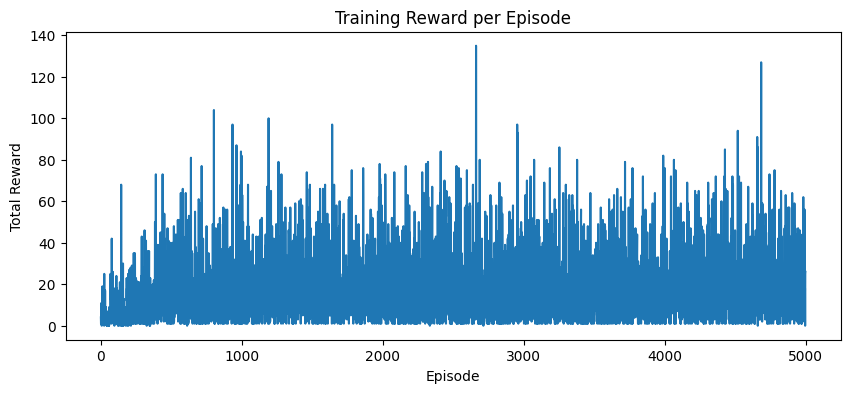

In [140]:
# Training loop 
for episode in range(num_episodes):
    dx = therace.reset()[0]  # initial dx (state is array with one element)
    done = False
    total_reward = 0

    while not done:
        # choose action
        action = select_action(dx, Q, epsilon)

        # take action
        next_state, reward, done = therace.step(action)
        next_dx = next_state[0]

        # Q-learning update
        s_idx = state_to_index(dx)
        a_idx = action_to_index(action)
        next_s_idx = state_to_index(next_dx)
        Q[s_idx, a_idx] += alpha * (reward + gamma * np.max(Q[next_s_idx]) - Q[s_idx, a_idx])

        dx = next_dx
        total_reward += reward


    # decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    reward_history.append(total_reward)

    # logging every 100 episodes
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(reward_history[-100:])
        print(f"Episode {episode+1} | Avg reward (last 100): {avg_reward:.2f} | epsilon: {epsilon:.3f}")

# Plot training reward 
plt.figure(figsize=(10,4))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

The heatmap below visualizes the learned Q-values for each state-action pair in our Minirace agent. The rows correspond to dx values (the relative position of the track in front of the car) and the columns correspond to actions (steer left, go straight, or steer right).

Each cell shows the expected cumulative reward (Q(s,a)) for taking that action in the given state. Darker colors indicate higher Q-values. By taking the action with the highest Q-value in each row, the agent defines a policy, which determines the preferred steering behavior for each dx.

From the table, we can see which actions the agent considers optimal for staying on track. For example, for dx = -2 the agent prefers action 0 (go straight), while for dx = 2 it prefers action 2 (steer right). This learned policy is then visually compared with a manual policy to evaluate how well the agent has captured the ideal driving strategy.

Best action for each dx:
dx = -2: action = 0
dx = -1: action = -2
dx = 0: action = -2
dx = 1: action = 0
dx = 2: action = 2


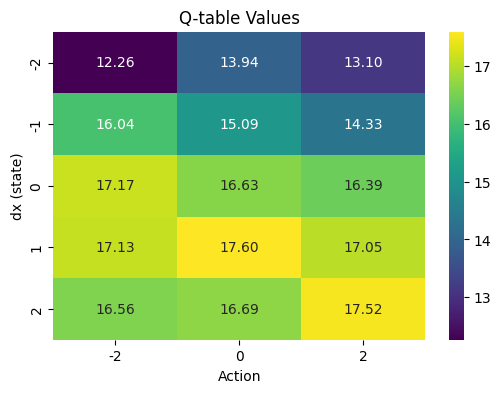

In [141]:
import seaborn as sns

# Convert Q-table to "best action" indices for each state
best_actions = np.argmax(Q, axis=1)  # 0=left, 1=straight, 2=right
best_action_labels = [actions[i] for i in best_actions]

print("Best action for each dx:")
for dx, action in zip(dx_values, best_action_labels):
    print(f"dx = {dx}: action = {action}")

# Heatmap of Q-values
plt.figure(figsize=(6,4))
sns.heatmap(Q, annot=True, fmt=".2f", xticklabels=actions, yticklabels=dx_values, cmap="viridis")
plt.xlabel("Action")
plt.ylabel("dx (state)")
plt.title("Q-table Values")
plt.show()


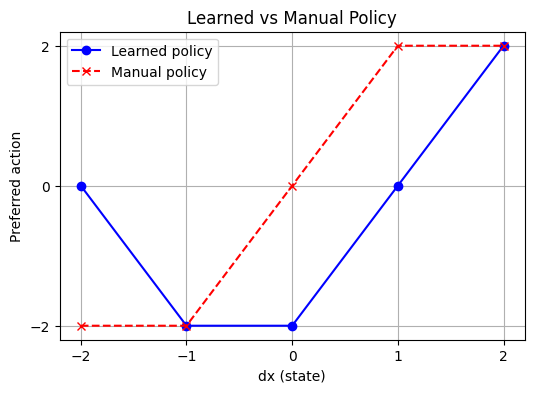

In [142]:
# dx values
dx_vals = dx_values  # [-2, -1, 0, 1, 2]

# Learned policy from Q-table
learned_actions = [actions[i] for i in np.argmax(Q, axis=1)]

# Ideal manual policy
manual_actions = [-2 if dx < 0 else 2 if dx > 0 else 0 for dx in dx_vals]

# Plot both policies
plt.figure(figsize=(6,4))
plt.plot(dx_vals, learned_actions, marker='o', linestyle='-', color='blue', label='Learned policy')
plt.plot(dx_vals, manual_actions, marker='x', linestyle='--', color='red', label='Manual policy')
plt.xticks(dx_vals)
plt.yticks(actions)
plt.xlabel("dx (state)")
plt.ylabel("Preferred action")
plt.title("Learned vs Manual Policy")
plt.legend()
plt.grid(True)
plt.show()


### Step 4: Testing and Evaluation

Run 50 test episodes using the trained policy, but with ϵ = 0.0 for all 50 episodes. Again, reset the environment at the beginning of each episode. Calculate the average over sum-of-rewards-perepisode (call this the Test-Average), and the standard deviation (the Test-StandardDeviation).

In [143]:
# Evaluation parameters 
num_test_episodes = 50
epsilon_test = 0.0  # fully exploit learned policy
test_rewards = []

# Run test episodes 
for episode in range(num_test_episodes):
    dx = therace.reset()[0]  # reset environment
    done = False
    total_reward = 0

    while not done:
        # select action using the learned Q-table (no exploration)
        s_idx = state_to_index(dx)
        a_idx = np.argmax(Q[s_idx])
        action = actions[a_idx]

        # take action
        dx, reward, done = therace.step(action)
        total_reward += reward

    test_rewards.append(total_reward)

# Compute test statistics 
test_avg = np.mean(test_rewards)
test_std = np.std(test_rewards)

print(f"Test-Average (mean cumulative reward): {test_avg:.2f}")
print(f"Test-StandardDeviation: {test_std:.2f}")

Test-Average (mean cumulative reward): 21.66
Test-StandardDeviation: 20.24


C:\Users\kyral\AppData\Local\Temp\ipykernel_2180\1866438442.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx_int = int(np.round(dx))
